In [1]:
import os
import random
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dropout,
    Dense,
    Rescaling,
)

Готовятся основные параметры и данные для дальнейшего использования в процессе обучения модели распознавания жестов.


In [2]:
PATH_TRAINING = "./data/train.csv"
PATH_TESTING = "./data/test.csv"
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 32
label_dict = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
    4: "E",
    5: "F",
    6: "G",
    7: "H",
    8: "I",
    10: "K",
    11: "L",
    12: "M",
    13: "N",
    14: "O",
    15: "P",
    16: "Q",
    17: "R",
    18: "S",
    19: "T",
    20: "U",
    21: "V",
    22: "W",
    23: "X",
    24: "Y",
}

Чтение данных из CSV-файлов:


In [3]:
pd_training = pd.read_csv(PATH_TRAINING)
pd_testing = pd.read_csv(PATH_TESTING)
pd_training.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
pd_testing.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


Этот код выполняет подсчет количества каждой метки в тренировочном и тестовом наборах данных и сортирует результаты по индексу (меткам).


In [5]:
pd_training.label.value_counts().sort_index()

label
0     1126
1     1010
2     1144
3     1196
4      957
5     1204
6     1090
7     1013
8     1162
10    1114
11    1241
12    1055
13    1151
14    1196
15    1088
16    1279
17    1294
18    1199
19    1186
20    1161
21    1082
22    1225
23    1164
24    1118
Name: count, dtype: int64

In [6]:
pd_testing.label.value_counts().sort_index()

label
0     331
1     432
2     310
3     245
4     498
5     247
6     348
7     436
8     288
10    331
11    209
12    394
13    291
14    246
15    347
16    164
17    144
18    246
19    248
20    266
21    346
22    206
23    267
24    332
Name: count, dtype: int64

Функция make_img преобразует DataFrame, содержащий плоские векторы пикселей, в массив изображений


In [7]:
def make_img(data):
    return data.values.reshape(len(data), 28, 28, 1)

Преобразование данных для обучения и тестирования модели, извлекая метки и преобразуя изображения в нужный формат.


In [8]:
label_training = pd_training.label.values
training_imgs = make_img(pd_training.drop("label", axis=1))
label_testing = pd_testing.label.values
test_imgs = make_img(pd_testing.drop("label", axis=1))

In [9]:
print(label_training.shape)
print(training_imgs.shape)
print(label_testing.shape)
print(test_imgs.shape)

(27455,)
(27455, 28, 28, 1)
(7172,)
(7172, 28, 28, 1)


Случайный выбор изображений из тренировочного набора данных и их отображение


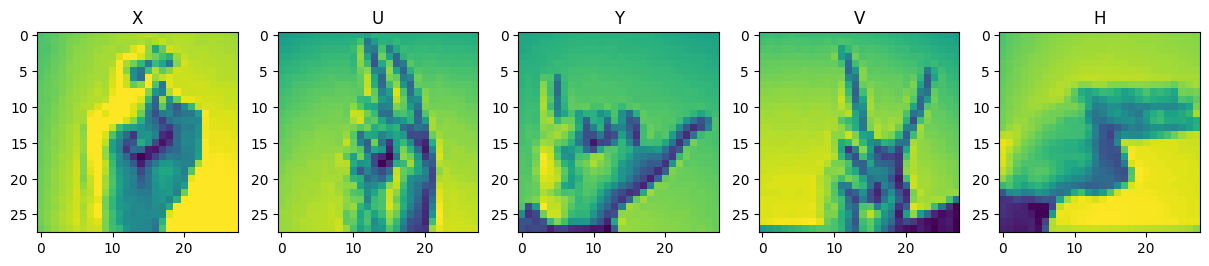

In [10]:
rand_nums = [random.randint(0, len(pd_training)) for i in range(5)]
rand_imgs = [training_imgs[i] for i in rand_nums]
rand_labels = [label_dict[pd_training.iloc[i, 0]] for i in rand_nums]
fig, axis = plt.subplots(1, 5, figsize=(15, 5))
for ax, img, label in zip(axis, rand_imgs, rand_labels):
    ax.imshow(img)
    ax.set_title(label)
plt.show()

In [11]:
label_training

array([ 3,  6,  2, ..., 18, 17, 23])

In [12]:
label_training = tf.one_hot(label_training, 25)
label_testing = tf.one_hot(label_testing, 25)

Создаем и настраиваем объект tf.data.Dataset для тренировочных данных, используя библиотеку TensorFlow. Объект будет содержать перемешанные, разбитые на пакеты, кэшированные и предварительно загруженные данные, что улучшит производительность обучения.


In [13]:
train_data = (
    tf.data.Dataset.from_tensor_slices((training_imgs, label_training))

    .shuffle(buffer_size=10000)

    .batch(BATCH_SIZE)
    .cache()

    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.int64, name=None), TensorSpec(shape=(None, 25), dtype=tf.float32, name=None))>

In [14]:
test_data = (
    tf.data.Dataset.from_tensor_slices((test_imgs, label_testing))

    .batch(BATCH_SIZE)

    .cache()

    .prefetch(buffer_size=tf.data.AUTOTUNE)

)

test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.int64, name=None), TensorSpec(shape=(None, 25), dtype=tf.float32, name=None))>

После выполнения этого кода модель нейронной сети будет создана и готова к компиляции и обучению. Метод model.summary() выводит структуру модели, включая количество параметров в каждом слое.


In [15]:
model = tf.keras.models.Sequential(
    [

        Input(shape=IMG_SHAPE),

        Rescaling(1.0 / 255),

        Conv2D(16, (3, 3), activation="relu"),

        MaxPooling2D(),

        Conv2D(32, (3, 3), activation="relu"),

        MaxPooling2D(),

        Flatten(),

        Dense(128, activation="relu"),

        Dense(25, activation="softmax"),

    ]
)

In [16]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=["accuracy"],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,553 (431.85 KB)

 Trainable params: 110,553 (431.85 KB)

 Non-trainable params: 0 (0.00 B)

Код ниже запускает процесс обучения модели с использованием метода fit из библиотеки TensorFlow и Keras.


In [17]:
history = model.fit(train_data, epochs=20, validation_data=test_data, verbose=2)

Epoch 1/20
858/858 - 8s - 9ms/step - accuracy: 0.6864 - loss: 1.0632 - val_accuracy: 0.8285 - val_loss: 0.5245
Epoch 2/20
858/858 - 4s - 5ms/step - accuracy: 0.9724 - loss: 0.1163 - val_accuracy: 0.9078 - val_loss: 0.2983
Epoch 3/20
858/858 - 4s - 5ms/step - accuracy: 0.9977 - loss: 0.0202 - val_accuracy: 0.9215 - val_loss: 0.2777
Epoch 4/20
858/858 - 4s - 5ms/step - accuracy: 0.9981 - loss: 0.0113 - val_accuracy: 0.9221 - val_loss: 0.2820
Epoch 5/20
858/858 - 4s - 5ms/step - accuracy: 0.9960 - loss: 0.0153 - val_accuracy: 0.9228 - val_loss: 0.2809
Epoch 6/20
858/858 - 4s - 5ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9268 - val_loss: 0.2949
Epoch 7/20
858/858 - 4s - 5ms/step - accuracy: 1.0000 - loss: 6.9984e-04 - val_accuracy: 0.9275 - val_loss: 0.2994
Epoch 8/20
858/858 - 4s - 5ms/step - accuracy: 1.0000 - loss: 3.6569e-04 - val_accuracy: 0.9325 - val_loss: 0.3061
Epoch 9/20
858/858 - 4s - 5ms/step - accuracy: 1.0000 - loss: 2.3714e-04 - val_accuracy: 0.9286 - val_lo

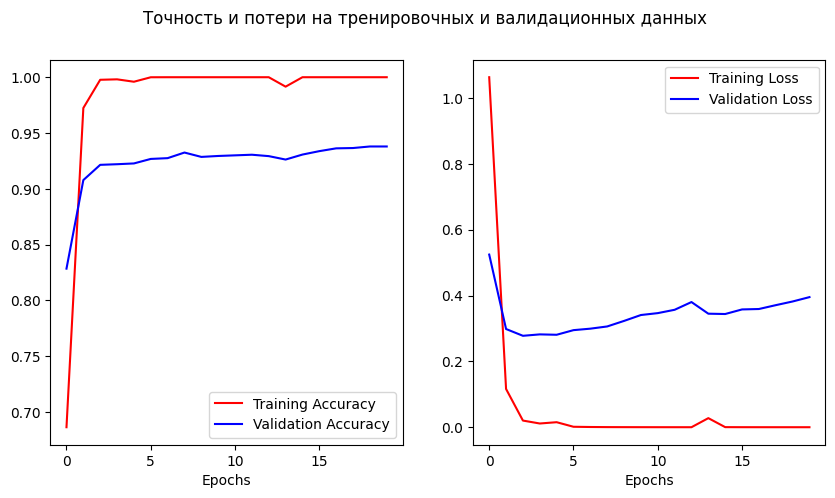

In [18]:
acc = history.history["accuracy"]
loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Точность и потери на тренировочных и валидационных данных")

for i, (data, label) in enumerate(
    zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])
):
    ax[i].plot(epochs, data[0], "r", label="Training " + label)
    ax[i].plot(epochs, data[1], "b", label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel("Epochs")

plt.show()